In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
project_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project"
data_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data"


The images in the dataset, as mentioned in the introduction are DICOM format. These require special package **pydicom** to be installed.

In [4]:
#install pydicom module if it has not been installed already
pydicom_exists = !ls /usr/local/lib/python3.6/dist-packages | grep pydicom

if(len(pydicom_exists) == 0):
  !pip install pydicom

     |████████████████████████████████| 35.3MB 87kB/s 


In [5]:
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)


TensorFlow 2.x selected.
2.1.0


In [0]:
#Import all the necessary modules

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pydicom as dcm
from PIL import Image

## Exploring the given Data files, classes and images of different classes

The dataset downloaded has the following files:
1. stage_2_detailed_class_info.csv
2. stage_2_train_labels.csv
3. stage_2_train_images - DICOM files
4. stage_2_test_images - DICOM files



In [7]:
patient_classes = pd.read_csv(data_path + "/stage_2_detailed_class_info.csv")
patient_classes.head(5).transpose()

,0,1,2,3,4
patientId,0004cfab-14fd-4e49-80ba-63a80b6bddd6,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,00322d4d-1c29-4943-afc9-b6754be640eb,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,00436515-870c-4b36-a041-de91049b9ab4
class,No Lung Opacity / Not Normal,No Lung Opacity / Not Normal,No Lung Opacity / Not Normal,Normal,Lung Opacity


The stage_2_detailed_class_info has the patient_id and the class which their Chest X-Ray belongs to. We will identify from the dataset how many different classes the X-Ray can belong to.

In [8]:
print("Unique Class names in the data set \n", patient_classes["class"].unique())

Unique Class names in the data set 
 ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


### The classification categories of the X-Ray images based on opacity
As we can see, based on the opacity of lungs in the X-Ray of the chest, they are classified into 3 categories:

**Normal** (Healthy lungs)

**No Lung Opacity/Not Normal** (unhealthy lungs but not indicative of Pneumonia)

**Lung Opacity** (Indicative of pneumonia)



In [9]:
train_labels = pd.read_csv(data_path + "/stage_2_train_labels.csv")
train_labels.sample(n=3).transpose()

,437,80,21134
patientId,0796d0a6-8aa5-4edf-9c82-33523d8da0c2,01fa0f5e-00c3-41cb-b5c7-10600c8633ae,bf9254b2-2d3a-444a-8dae-a27f02b0e9ef
x,NaN,602,154
y,NaN,438,456
width,NaN,101,207
height,NaN,101,195
Target,0,1,1


stage_2_train_labels.csv contains the patientId mapped to x, y, height, width and target where (x,y) is the pixel where the opacity is identified and height and width are that of the opacity from the (x,y) position. These values as not a valid number for patients who have no opacity detected. If we observe, the Target of the patients with opacity is 1 and the ones with no opactiy is 0. 

In [10]:
print("Unique Target names in the data set \n", train_labels["Target"].unique())

Unique Target names in the data set 
 [0 1]


**patient_classes** dataset has information about the patient id and the classification of the patient's X-Ray into one of the three possible classes. 

**train_labels** dataset provides the position of pneumonia in the lung in the form of (x,y) starting point of the opacity on the image followed by the width and height of the opacity. It also has a Target column which has values 0 if the patient is not diagnosed for pneumonia and 1 otherwise. Those patients with a target of 0 (no pneumonia) do not have binding box values. These binding boxes are needed to train models to perform object detection, where the location of the object will be highlighted.

Let's try to retrieve the number of unique patient records where the target is 1, meaning the patient has pneumonia. 

In [11]:
print(len(np.unique((train_labels[train_labels['Target'] == 1])['patientId'])))

6012


So we have 6012 patients each of who have one or more than one lung opacity, which is indicative of Pneumonia.

In this case study model building, our focus is only to detect the cases of pneumonia. Any abnormality other than pneumonia is beyond the scope of the model we are building. Let's determine the relation between the class and target before proceeding further. For this purpose, we will merge the two datasets and analyse.

In [12]:
patientInfo_df = pd.merge(train_labels, patient_classes, left_on='patientId', right_on='patientId', how='inner')
patientInfo_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


3


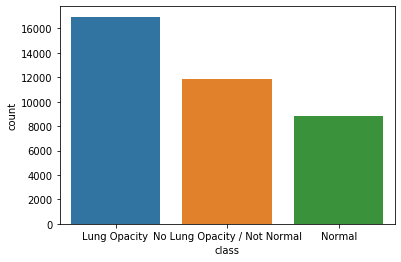

In [13]:
class_count = len(np.unique(patientInfo_df['class']))
print(class_count)
sns.countplot(patientInfo_df['class'],order = np.unique(patientInfo_df['class']))
plt.show()

In [14]:
print(np.unique((patientInfo_df[patientInfo_df['Target'] == 0])['class']))

['No Lung Opacity / Not Normal' 'Normal']


In [15]:
print(np.unique((patientInfo_df[patientInfo_df['Target'] == 1])['class']))

['Lung Opacity']


It is evident from the print statements that all the records belonging to class 'Normal' and 'No Lung Opacity / Not Normal' come under Target 0, which indicates the X-ray under subject is not diagnosed for Pneumonia and all the records belonging to class 'Lung Opacity' come under Target 1. 


As the objective of our model is only to identify whether an X-ray image has opacities which are indicative of Pneumonia or not, we are only concerned about the Target column. We can leave out the class column from our model-building. We will build a model which can do a binary classification of the images belonging to class 1 if there is a possibility of Pneumonia and class 0 otherwise. 

In [0]:
patientInfo_df.drop('class',axis=1,inplace=True)

##Number of patients with no pneumonia

In [28]:
numNonPneumoniaPatients = len(np.unique((patientInfo_df[patientInfo_df['Target'] == 0])['patientId']))
print("Number of patients who have no pneumonia in the dataset ",numNonPneumoniaPatients)

num_NonPneumoniaRecords = len(patientInfo_df[patientInfo_df['Target'] == 0]['patientId'])
print("Number of patient records for patients who have no pneumonia in the dataset  ",num_NonPneumoniaRecords)

Number of patients who have no pneumonia in the dataset  20672
Number of patient records for patients who have no pneumonia in the dataset   20672


## Number of patients with pneumonia

In [29]:

numPneumoniaPatients = len(np.unique((patientInfo_df[patientInfo_df['Target'] == 1])['patientId']))
print("Number of patients who have pneumonia in the dataset ",numPneumoniaPatients)

num_PneumoniaRecords = len(patientInfo_df[patientInfo_df['Target'] == 1]['patientId'])
print("Number of patient records for patients who have pneumonia in the dataset ",num_PneumoniaRecords)

Number of patients who have pneumonia in the dataset  6012
Number of patient records for patients who have pneumonia in the dataset  16957


The merged dataset **patientInfo_df** has 16957 records of patients who have Pneumonia. However there are only 6012 unique patients who have Pneumonia. Patients have multiple records for each opacity identified in their chest X-Ray. Let's explore into the number of opacities patients have.

In [30]:
tmp = patientInfo_df.groupby(['patientId','Target'])['patientId'].count()
df = pd.DataFrame(data={'Bounding Box': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Bounding Box','Target']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Bounding Box', 'Target', 'Entries']
df2



,Bounding Box,Target,Entries
0,1,0,20672
1,1,1,2614
2,4,1,3266
3,9,1,119
4,16,1,13


In [103]:
tmp


patientId
Bounding Box Target           
1            0           20672
             1            2614
4            1            3266
9            1             119
16           1              13

The above print statements indicate that for 13 patients, there were 16 bounding boxes, for 119 patients there were 9 bounding boxes, for 3266 patients there were 4 bounding boxes and for 2614 patients there was just one bounding box. The bounding box highlights the luncg opacity. 

##Subject Matter Expert Opinion
Talking to a field expert about these counts suggested that higher number of opacities indicate that the infection is fast spreading and might require immediate medical intervention. But the objective of this model building is binary classification and the severity of the individual cases, is beyond the scope of this exercise.


,pnuemonia_pat,Unique pnuemonia_pat,No pnuemonia_pat,Unique No pnuemonia_pat
0,16957,6012,20672,20672


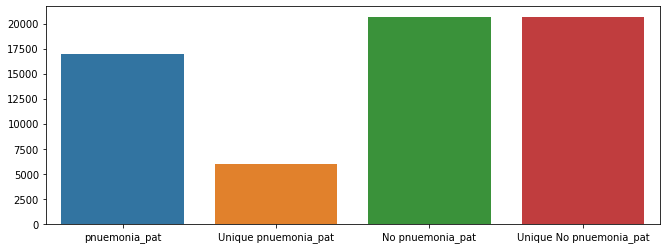

In [32]:
data ={'pnuemonia_pat':[num_PneumoniaRecords], 
        'Unique pnuemonia_pat':[numPneumoniaPatients], 
        'No pnuemonia_pat':[num_NonPneumoniaRecords], 
        'Unique No pnuemonia_pat':[numNonPneumoniaPatients]}
        # Convert the dictionary into DataFrame 
plt.figure(figsize=[11,4])
df = pd.DataFrame(data)
g=sns.barplot(data =df)
plt.show
df

# Dealing with Missing values

We have to check if any label that is of the +ve class has Nulls in the bounding boxes data. Since only bounding boxes in the 0 class can have nulls since we will not draw bounding boxes in these cases.

In [33]:
print("The number of NaN values for bounding box dimentions columns for class 1 data = %s " % patientInfo_df[patientInfo_df.Target == 1].isna().sum() )


The number of NaN values for bounding box dimentions columns for class 1 data = patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64 


There are no null values in the dataset for patients with pneumonia which means the bounding boxes for the opacity is present for all patients who are diagnosed positive for pneumonia. 

##Exploring images
The images in the dataset provided are in DICOM format. These files have the images along with the metadata which includes the patientId and details of the patients and the details of the image. 

In [36]:
dcm_file = project_path + '/data/stage_2_train_images/%s.dcm' % patientInfo_df.patientId.tolist()[0]
dcm_data = dcm.dcmread(dcm_file)
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

According to the subject matter expert we discussed with, the age of the patient is imperative in treatment of Pneumonia as the infection spreads much faster. The impact of gender is questionable. The other metadata of the image is imperative in tuning the model hyper parameters and for augmenting the data passed to the model later for accuracy in prediction. 

Let us merge all the meta data information also with patientInfo dataframe for further analysis and usage. We will extract the images and store them as JPG files in folders named, training_images and test_images. The JPG files in training_images will be used to train and validate the model. There are no labels available for the test images. 

In [38]:
%cd /content/gdrive/My Drive/Colab Notebooks/Capstone Project/data
PATH = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/"

if not os.path.exists('training_images'):
    os.makedirs('training_images')
if not os.path.exists('test_images'):
    os.makedirs('test_images')


/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data


In [104]:
def process_dicom_data(data_df):
    for idx, data_row in data_df.iterrows():
        imgName = str(data_row['patientId'])
        fullpath = PATH+"train_images/"+imgName+".jpg"
        if(os.path.exists(fullpath)):
          continue
        imagePath = PATH+"stage_2_train_images/"+imgName+".dcm"
        try:
          data_row_img_data = dcm.read_file(imagePath)
          data_row_img = dcm.dcmread(imagePath)
          jpegFileName = "./training_images/"+imgName+".jpg"
          if not os.path.exists(jpegFileName):
            img = Image.fromarray(data_row_img.pixel_array)
            img.save(jpegFileName)
          idx = (data_df['patientId']==data_row_img_data.PatientID)
          data_df.loc[idx,'Image'] = fullpath
          data_df.loc[idx,'Modality'] = data_row_img_data.Modality
          data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
          data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
          data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
          data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
          data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
          data_df.loc[idx,'Rows'] = data_row_img_data.Rows
          data_df.loc[idx,'Columns'] = data_row_img_data.Columns  

          data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 
        except:
          print("Exception in reading DICOM for patient ",imgName)
          continue



if not os.path.exists("./patients_data.csv"):
  process_dicom_data(patientInfo_df)
  patientInfo_df.to_csv("./patients_data.csv")
else:
  patientInfo_df = pd.read_csv('patients_data.csv')

patientInfo_df.drop('Unnamed: 0',axis=1,inplace=True)	
patientInfo_df.sample(n=4).transpose()

,9948,1013,30934,28660
patientId,5840f27f-0a9e-45b8-a849-4a379ecace6f,09e8fae9-1714-4b54-a1d3-42a29a9717c3,dd53ca39-9356-470c-b7e5-fa204a2de17f,cc143014-e24a-4ac2-be70-7de06c82456d
x,NaN,NaN,NaN,NaN
y,NaN,NaN,NaN,NaN
width,NaN,NaN,NaN,NaN
height,NaN,NaN,NaN,NaN
Target,0,0,0,0
Image,/content/gdrive/My Drive/Colab Notebooks/Capst...,/content/gdrive/My Drive/Colab Notebooks/Capst...,/content/gdrive/My Drive/Colab Notebooks/Capst...,/content/gdrive/My Drive/Colab Notebooks/Capst...
Modality,CR,CR,CR,CR
PatientAge,10,61,10,42
PatientSex,M,M,M,M


In [42]:
#Extracting the test images and dataset
def process_dicom_test_data():

  data_df = pd.DataFrame(columns=['patientId', 'Image', 'Modality','PatientAge','PatientSex','BodyPartExamined','ViewPosition','ConversionType','Rows','Columns','PixelSpacing'])
  idx=0
  test_images_path = PATH+"stage_2_test_images/"
  test_images = os.listdir( test_images_path )

  for test_img in test_images:
      if test_img.endswith(".dcm"):
        try:
          data_row_img_data = dcm.read_file(test_images_path+test_img)
          data_row_img = dcm.dcmread(test_images_path+test_img)
          imgName = test_img[:-4]
          jpegFileName = "./test_images/"+imgName+".jpg"
          if not os.path.exists(jpegFileName):
            img = Image.fromarray(data_row_img.pixel_array)
            img.save(jpegFileName)
          data_df.loc[idx,'Image'] = imgName+".jpg"
          data_df.loc[idx,'Modality'] = data_row_img_data.Modality
          data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
          data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
          data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
          data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
          data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
          data_df.loc[idx,'Rows'] = data_row_img_data.Rows
          data_df.loc[idx,'Columns'] = data_row_img_data.Columns  

          data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 
          idx = idx + 1
        except:
          print("Exception in reading DICOM for patient ",imgName)
          continue
  return data_df

total_test_images = len(os.listdir("./test_images/"))

#If test images are already extracted, skip extraction.
if total_test_images == 0:
  data_df = process_dicom_test_data()
  data_df.to_csv("./patients_data_test.csv")
else:
  data_df = pd.read_csv("./patients_data_test.csv")
total_test_images = len(os.listdir("./test_images/"))

print("There are ", total_test_images, " test images")

There are  3000  test images


# Visualizing different classes

We will extract 9 random images of patients who have been diagnosed with Pneumonia and draw the bounding boxes on images indicating opacity.

<Figure size 432x288 with 0 Axes>

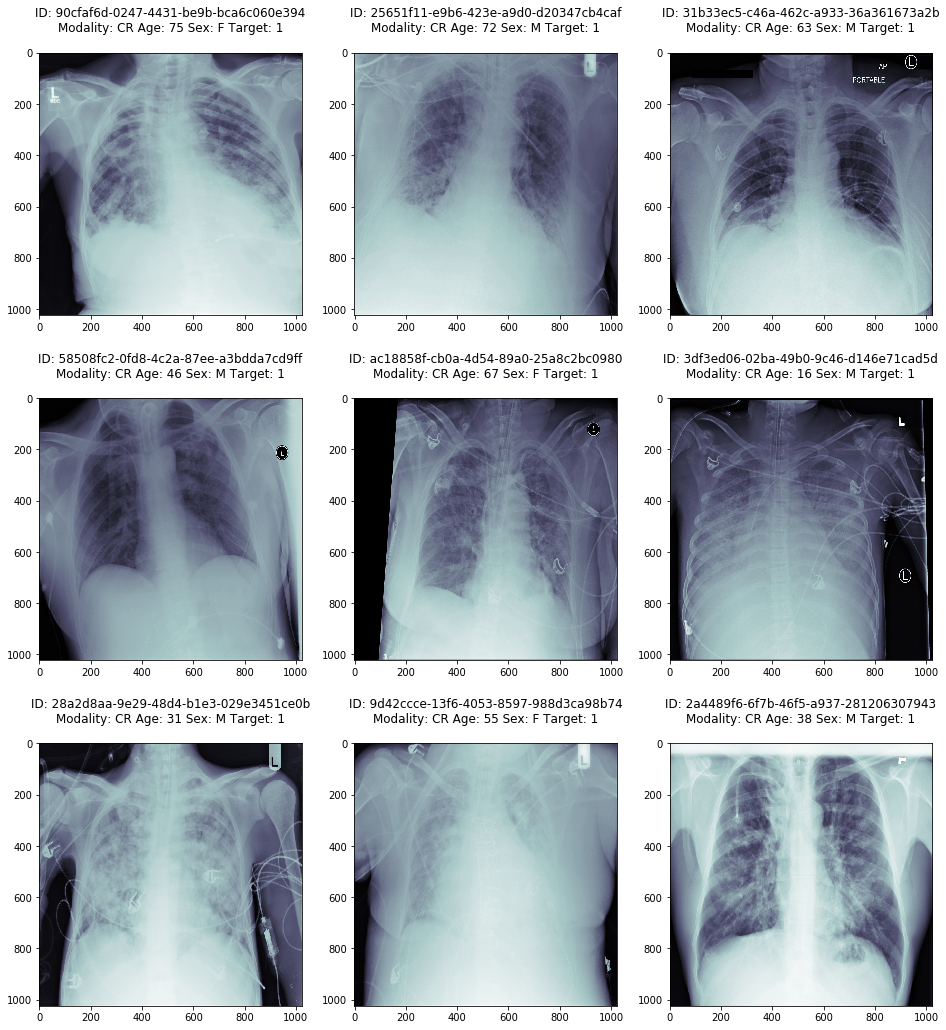

In [44]:
samplePatientIDList = patientInfo_df[patientInfo_df['Target'] == 1].sample(9)
f = plt.figure()

f, ax = plt.subplots(3,3, figsize=(16,18))

def show_dicom_images(data_set):
    i=0
    for idx,data_row in data_set.iterrows():
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\n'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target']))
        i = i+1
    
show_dicom_images(samplePatientIDList)
plt.show()


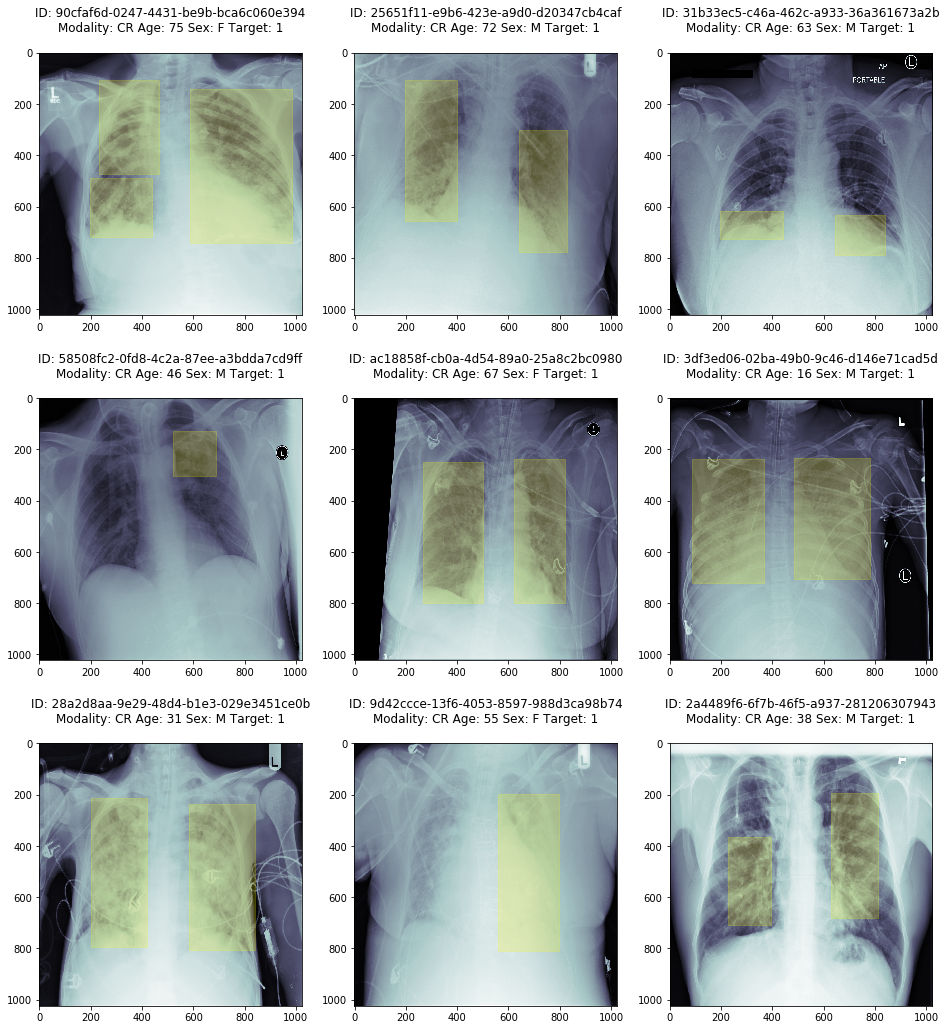

In [45]:
def show_opactiy_boxes(data_set):
  i=0
  for idx,data_row in data_set.iterrows():

    rows = train_labels[train_labels['patientId']==data_row['patientId']]
    box_data = list(rows.T.to_dict().values())
    for j, row in enumerate(box_data):
      ax[i//3, i%3].add_patch(patches.Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color='yellow', alpha = 0.2))   
    i=i+1  

show_opactiy_boxes(samplePatientIDList)

f

In [69]:
# number of unique patients
print ("Total no. of unique pateints", patientInfo_df['patientId'].nunique())

Total no. of unique pateints 26684


Let's create a dataset from the balanced_patient_dataset which only has the columns we are going to take into consideration for solely visual analysis purpose. 

In [0]:

tmp_dataset = patientInfo_df[['patientId','PatientAge','PatientSex','Target']]

In [0]:
tmp_dataset = tmp_dataset.drop_duplicates(subset="patientId",keep='last',inplace=False)

In [72]:
tmp_dataset.head(5)

,patientId,PatientAge,PatientSex,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,19.0,M,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,28.0,M,0
7,00436515-870c-4b36-a041-de91049b9ab4,32.0,F,1


In [78]:
tmp_dataset[tmp_dataset['Target'] == '0']

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,patientId,PatientAge,PatientSex,Target


,Pneumonia,Non Pneumonia
0,6012,20672


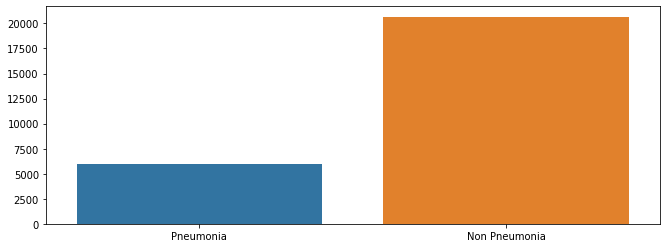

In [84]:

data ={'Pneumonia':[len(np.unique((patientInfo_df[patientInfo_df['Target'] == 1])['patientId']))], 
        'Non Pneumonia':[len(np.unique((patientInfo_df[patientInfo_df['Target'] == 0])['patientId']))]}

plt.figure(figsize=[11,4])
df = pd.DataFrame(data)
g=sns.barplot(data =df)
plt.show
df

M    21497
F    16129
Name: PatientSex, dtype: int64


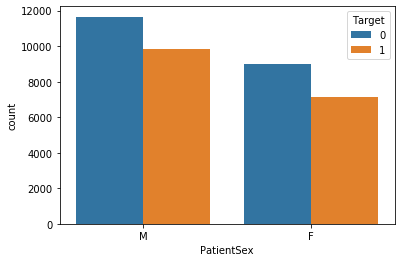

In [86]:
#Breakup of the dataset w.r.t their sex
print(patientInfo_df['PatientSex'].value_counts())

#multivariant analysis to see the spread of sex w.r.t if they have pneumonia or non-pneumonia patient
sns.countplot(x = 'PatientSex', hue = 'Target', data = patientInfo_df)

Reference to some resources available [online](https://medium.com/health-and-disease/women-are-less-likely-than-men-to-get-pneumonia-b374d34d18e4
) and discussion with subject matter experts indicate that men are more likely to be affected by Pneumonia than women. 

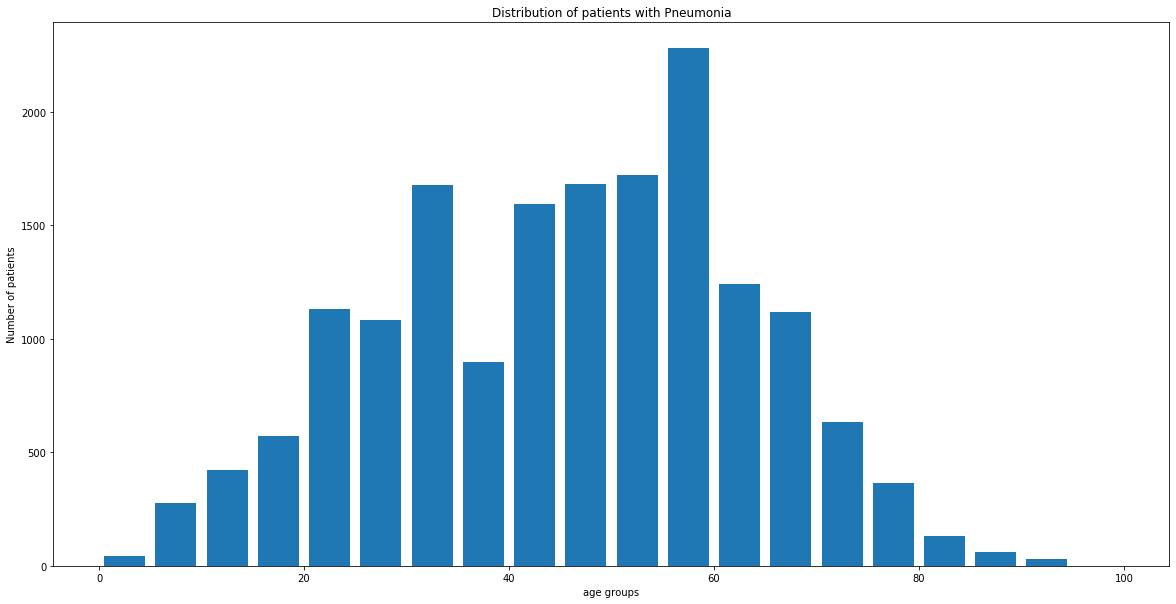

In [87]:
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
plt.figure(figsize=(20,10))
plt.hist(patientInfo_df[patientInfo_df['Target'] == 1]['PatientAge'], bins, histtype='bar', rwidth=.8)
plt.xlabel('age groups')
plt.ylabel('Number of patients')
plt.title('Distribution of patients with Pneumonia')
plt.show()

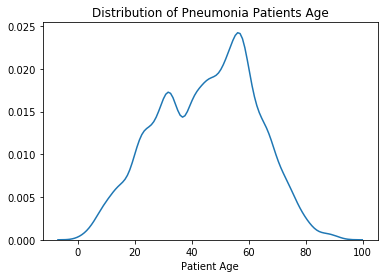

In [88]:
# Same is visualized using a density plot
# there is a bi-modal distribution seen wherein we have 2 peaks
sns.kdeplot(patientInfo_df[patientInfo_df['Target'] == 1]['PatientAge'].values).set_title("Distribution of Pneumonia Patients Age")
plt.xlabel('Patient Age')
plt.show()

Below boxplot shows that there are few outliers at the upper end (PatientAge > 92) and 1 outline at the lower end (PatientAge < 1). The latter outliner is due to the update done to convert NaN to 0

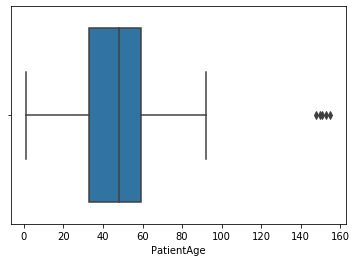

In [90]:
sns.boxplot(patientInfo_df['PatientAge'])
plt.show()


We can see that we have some outliers in Age. This might be due to incorrect entry of data or actual outlier. But for the purpose of this model building, age doesn't have correlation in detection of pneumonia. We will not treat the outliers. There is evidence based on scholarly articles that though Pneumonia is the major cause for death among infants, adult of older age are more likely to respond less to treatment if not done on time. 

Find below the scholarly evidences referred to:

https://www.thoracic.org/patients/patient-resources/resources/top-pneumonia-facts.pdf


##Summary of EDA

To summarize all the observation on the data provided,
1. No Lung Opacity / Not Normal' and 'Normal' classes are considered non pneumonia. Where as 'Lung Opacity' is considered Pneumonia.
2. The data is imbalanced with more cases of Non Pneumonia cases. This might result in the senstivity of the model to be low, if the data is not balanced. Given the statistics of death caused by Pneumonia, it is imperative to balance the data.
3. Pneumonia seems to occur in more people between age group of 30-60 yrs of age. This may be possibly be indicative of the demographic distribution. However, there is no substantiating evidence of this.
4. In the given dataset, more men have Pneunmonia than women. The scholarly articles referred to concur with the findings of the dataset. 


##Model Building

###Training data:
We considered few ways of balancing the data and built a 5 Layer Convultion model and a 3 convultion layer model. We tested the two models on the basis of the data we had and finalized on the 3 Conv layer as shown below which at the time of most recent running produced the following statistics. 

CONFUSION MATRIX ------------------

[[ 255  992]

 [ 714 2630]]

Validation METRICS ----------------------

Accuracy: 62.84033979525157%

Precision: 72.61181667586969%

Recall: 78.64832535885168%

F1-score: 75.50961814527707

TRAINING METRIC ----------------------

Train acc: 85.92

VALIDATION METRIC ----------------------

Train acc: 84.73



In [0]:

# Deep learning libraries
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

from sklearn.utils import resample,shuffle
from sklearn.model_selection import train_test_split



We will extract a subset of the dataset which is balanced before we run the test - a dataset which has equal distribution of Target 1 and 0. Since the number of Target 1 cases are about 6000 , we will take 6000 of Target 0 cases.

In [92]:
#Extract all the records with target 1
pneumonia_df = patientInfo_df[patientInfo_df['Target'] == 1]

#Extract all the records with target 0 and randomly select 6000 unique records from those.
nonpneumonia_df = resample(patientInfo_df[patientInfo_df['Target'] == 0],n_samples=6000,random_state=5,replace=False)
print(nonpneumonia_df.shape)

(6000, 16)


Target
0    0.4995
1    0.5005
dtype: float64
1    6012
0    6000
Name: Target, dtype: int64


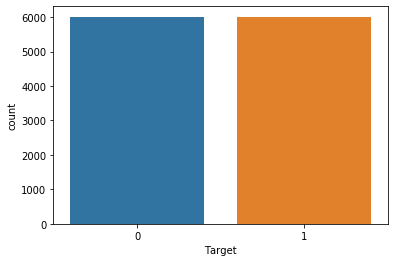

In [93]:
balanced_dataset = shuffle(pd.concat([pneumonia_df,nonpneumonia_df]))

tmp_dataset = balanced_dataset.drop_duplicates(subset="patientId",keep='last',inplace=False)
sns.countplot(tmp_dataset['Target'])
print(tmp_dataset.groupby('Target').size() / tmp_dataset.shape[0])
print(tmp_dataset['Target'].value_counts())

In [94]:
# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

balanced_dataset = balanced_dataset[patientInfo_df['Image'].isnull() == False]

train_df,test_df = train_test_split(balanced_dataset[['patientId','Target','Image']], test_size=0.2)

train_df['AbsoluteImage'] = train_df['patientId']+".jpg"
test_df['AbsoluteImage'] = test_df['patientId']+".jpg"

train_df['StrTarget'] = train_df['Target'].astype(str)
test_df['StrTarget'] = test_df['Target'].astype(str)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [0]:
# Hyperparameters
img_dims = 192
epochs = 10
batch_size = 64


In [96]:
    # Data generation objects
    input_path = '/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/training_images/'
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, horizontal_flip=True)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_dataframe(
    directory=input_path,
    dataframe=train_df,
    x_col='AbsoluteImage',
    y_col = 'StrTarget', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary',
    validate_filenames= False)
    

Found 18364 non-validated image filenames belonging to 2 classes.
Found 4591 non-validated image filenames belonging to 2 classes.


In [0]:
#Input layer
from tensorflow.keras.models import load_model
  
inputs = Input(shape=(img_dims, img_dims, 3))

x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Flatten()(x)

x = Dropout(rate=0.5)(x)
x = Dense(units=512, activation='relu')(x)
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)

if(os.path.exists("PneumoniaModel.h5")):
  model = load_model("PneumoniaModel.h5")
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:  
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [101]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0     

In [102]:
if(os.path.exists("best_weights.hdf5")):
  model.load_weights("best_weights.hdf5")

hist = model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=val_gen, 
           validation_steps=val_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 286 steps, validate for 71 steps
Epoch 1/10
286/286 [==============================] - 3330s 12s/step - loss: 0.3653 - accuracy: 0.8426 - val_loss: 0.3820 - val_accuracy: 0.8365
Epoch 2/10
286/286 [==============================] - 334s 1s/step - loss: 0.3620 - accuracy: 0.8483 - val_loss: 0.3734 - val_accuracy: 0.8385
Epoch 3/10
285/286 [============================>.] - ETA: 0s - loss: 0.3622 - accuracy: 0.8487
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
286/286 [==============================] - 340s 1s/step - loss: 0.3618 - accuracy: 0.8489 - val_loss: 0.3782 - val_accuracy: 0.8393
Epoch 4/10
286/286 [==============================] - 344s 1s/step - loss: 0.3477 - accuracy: 0.8550 - val_loss: 0.3683 - val_accuracy: 0.8400
Epoch 5/10
285/286 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8590
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.0000004274770

In [105]:
model.save_weights("best_weights.hd5")
print("Saved model to disk")

Saved model to disk


In [0]:
model.save("PneumoniaModel.h5")

In [112]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(val_gen)

val_gen = train_datagen.flow_from_dataframe(
directory=input_path,    
dataframe=test_df,
x_col='AbsoluteImage',
y_col = 'StrTarget', 
target_size=(img_dims, img_dims), 
batch_size=batch_size, 
class_mode='binary',
validate_filenames= False)

preds = model.predict(val_gen)

acc = accuracy_score(test_df['Target'], np.round(preds))*100
cm = confusion_matrix(test_df['Target'], np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('Validation METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAINING METRIC ----------------------') 
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

print('\nVALIDATION METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['val_accuracy'][-1])*100, 2)))

Found 4591 non-validated image filenames belonging to 2 classes.
CONFUSION MATRIX ------------------
[[ 255  992]
 [ 714 2630]]
Validation METRICS ----------------------
Accuracy: 62.84033979525157%
Precision: 72.61181667586969%
Recall: 78.64832535885168%
F1-score: 75.50961814527707

TRAINING METRIC ----------------------
Train acc: 85.92

VALIDATION METRIC ----------------------
Train acc: 84.73


## Other Models and Data Balancing considered

The below table summarizes the few models and data set and balancing we considered before deciding to finalize on the 3 Conv layer shown above for initial binary classification. Our decision was based on the Validation dataset accuracy and sensitivity of the data based on test data. These tests have been submitted on a separate notebook along with the submission.

<table>
<tr>
<th>S.No</th><th>Model</th><th>Data Balanced</th><th>Data Balance Methodology</th><th>Training Accuracy</th><th>Validation Accuracy</th><th>F1 Score</th>
<th>Consideration</th>
</tr>
<tr>
<td>1</td>
<td>5 Conv layers</td>
<td>Yes</td>
<td>Dropped 'No Lung Opacity/Not Normal' </td>
<td>90</td>
<td>91</td>
<td>92</td>
<td>Might be overfitting. </td>
</tr>

<tr>
<td>2</td>
<td>5 Conv layers</td>
<td>No</td>
<td></td>
<td>80</td>
<td>81</td>
<td>78</td>
<td>Not Balanced. Sensitivity might be low</td>
</tr>

<tr>
<td>3</td>
<td>5 Conv layers</td>
<td>Yes</td>
<td>Randomly selected 6000 Target 0 cases</td>
<td>86</td>
<td>85</td>
<td>76</td>
<td>Worth considering as final model. But too many layers</td>
</tr>

<tr>
<td>4</td>
<td>3 Conv layers</td>
<td>Yes</td>
<td>Dropped 'Not Normal'</td>
<td>93</td>
<td>91</td>
<td>90</td>
<td>Might be overfitting. </td>
</tr>

<tr>
<td>5</td>
<td>3 Conv layers</td>
<td>Yes</td>
<td>Randomly selected 6000 Target 0 cases</td>
<td>85</td>
<td>84</td>
<td>75</td>
<td>Possibly accuracy will increase after more epoch. Good result on Test data as shown in additional notebook attached. Worth considering as final model.</td>
</tr>
</table>


## Next steps
The course of action planned for the second phase of the project is to use pretrained models and build a new one to produce the bounding boxes keeping the bench mark accuracy as rendered by the initial model. Few pretrained models we are considering are:
1. YOLO
2. CheXNet
3. MaskRCNN